In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from category_encoders.wrapper import PolynomialWrapper

#### Reading dataset.csv

In [234]:
df = pd.read_csv('./data/dataset.csv', low_memory=False)
df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
df.rename(columns = {'country': 'circuit_country'}, inplace = True)
df.drop(columns=['index'], inplace=True)
df.columns

Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time',
       'circuit_id', 'weather_warm', 'weather_cold', 'weather_dry',
       'weather_wet', 'weather_cloudy', 'resultId', 'driverId',
       'constructorId', 'car_number', 'grid', 'results_positionOrder',
       'results_points', 'laps', 'milliseconds', 'fastestLap',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'status',
       'circuit_location', 'circuit_country', 'constructorStandingsId',
       'constructor_points', 'constructor_position', 'constructor_wins',
       'constructorRef', 'constructor_nationality', 'driverRef',
       'driver_number', 'driver_code', 'forename', 'dob', 'driver_nationality',
       'driverStandingsId', 'driver_points', 'driver_position', 'driver_wins',
       'qualifyId', 'number', 'qualifying_position', 'q1_time', 'q2_time',
       'q3_time', 'no_of_stops', 'ms_avg', 'first_5_avg_time',
       'last_10_avg_time', 'lap_position_after_5',
       'lap_position_before_last_10'],


#### Dropping the columns

In [235]:
cols_to_be_dropped = ['raceId', 'year', 'round', 'name', 'time', 'circuit_id', 'car_number', 'resultId', 'driverRef', 'results_points', 'laps', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'first_5_avg_time', 'last_10_avg_time', 'lap_position_after_5', 'lap_position_before_last_10', 'circuit_location', 'constructorStandingsId', 'constructorRef', 'constructor_points', 'driverRef', 'driver_number', 'driver_code', 'forename', 'driverStandingsId', 'driver_points', 'number', 'status', 'qualifying_position', 'q1_time', 'q2_time', 'q3_time', 'ms_avg', 'no_of_stops', 'driver_position', 'qualifyId']
df_after_dropping = df.drop(columns = cols_to_be_dropped)

#### Getting age from date & dob

In [236]:
from datetime import datetime
from dateutil import relativedelta

# get two dates
race_date = df_after_dropping['date']
driver_dob = df_after_dropping['dob']

ages = []

for i in range(len(race_date)):
    start_date = datetime.strptime(race_date[i],"%Y-%m-%d")
    end_date = datetime.strptime(driver_dob[i], "%Y-%m-%d")
    delta = relativedelta.relativedelta(start_date, end_date)
    ages.append(delta.years)

df_after_dropping['driver_age'] = ages
df_after_dropping.drop(columns = ['date', 'dob'], inplace = True)
df_after_dropping

,circuitId,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driverId,constructorId,grid,results_positionOrder,milliseconds,statusId,circuit_country,constructor_position,constructor_wins,constructor_nationality,driver_nationality,driver_wins,driver_age
0,1,1.0,0.0,0.0,0.0,0.0,18,23,1,1,5655784,1,Australia,1.0,1.0,British,British,1.0,29
1,1,0.0,0.0,1.0,0.0,0.0,18,16,4,6,5126355,1,Australia,4.0,0.0,British,British,0.0,24
2,1,1.0,0.0,1.0,1.0,0.0,18,16,8,10,5748074,1,Australia,6.0,0.0,British,British,0.0,23
3,1,0.0,0.0,0.0,1.0,1.0,18,1,4,1,5616531,1,Australia,2.0,1.0,British,British,1.0,30
4,1,0.0,0.0,0.0,0.0,0.0,18,1,4,6,5424563,1,Australia,2.0,0.0,British,British,0.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25655,66,0.0,0.0,1.0,0.0,0.0,720,6,19,8,\N,111,Switzerland,NaN,NaN,Italian,Swiss,0.0,34
25656,66,1.0,0.0,0.0,0.0,0.0,720,141,21,21,\N,121,Switzerland,NaN,NaN,French,Swiss,0.0,33
25657,66,0.0,0.0,1.0,0.0,0.0,719,133,18,9,\N,116,Switzerland,NaN,NaN,British,Swiss,0.0,45
25658,67,0.0,0.0,1.0,0.0,0.0,783,154,16,16,\N,5,Spain,NaN,NaN,French,French,0.0,46


#### Changing status IDs to 0s and 1s

In [237]:
df_after_dropping['statusId'][df_after_dropping['statusId'] > 1] = 0

C:\Users\nipun\AppData\Local\Temp\ipykernel_3916\639805009.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Replace Nan in Constructor_position by max Value = 21 & Replace Nan in Constructor_wins by 0

In [238]:
df_after_dropping['constructor_position'] = df_after_dropping['constructor_position'].fillna(21)
df_after_dropping['constructor_wins'] = df_after_dropping['driver_wins'].fillna(0)

## Analysis Graphs

In [239]:
# Drivers by nationality
nationality_driver = df_after_dropping.groupby(['driver_nationality'])['driver_nationality'].count().sort_values(ascending = False).reset_index(name = 'number_of_drivers')
nationality_driver['driver_nationality'][nationality_driver['number_of_drivers'] < 200] = 'Other'
nationality_driver = nationality_driver.groupby(['driver_nationality']).sum().reset_index()

fig = go.Figure(data=go.Pie(labels = nationality_driver['driver_nationality'], values=nationality_driver.number_of_drivers))
fig.update_layout(title = 'Drivers by Nationality')
fig.show()


C:\Users\nipun\AppData\Local\Temp\ipykernel_3916\1005006657.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [240]:
# Champions by nationality
champions = df_after_dropping[df_after_dropping['results_positionOrder'] == 1]
champions = champions.groupby(['driver_nationality'])['driver_nationality'].count().sort_values(ascending = False).reset_index(name = 'number_of_drivers')

fig = go.Figure(data=go.Pie(labels = champions['driver_nationality'], values=champions.number_of_drivers))
fig.update_layout(title = 'Champions by Driver Nationality')
fig.show()

In [241]:
# Completion rate by circuit
status_on_circuits = df_after_dropping[['circuitId', 'statusId']].groupby(['circuitId']).mean()
fig = px.bar(status_on_circuits, y = 'statusId')
fig.update_layout(title = 'Completion rate by circuit')
fig.show()

In [242]:
len(df_after_dropping.columns)

19

In [243]:
winners = df_after_dropping[['driverId', 'results_positionOrder', 'driver_age']][df_after_dropping['results_positionOrder'] == 1]
winners.drop(columns = ['driverId'], inplace=True)
winners_by_age = winners.groupby(['driver_age']).sum()
fig = px.bar(winners_by_age)
fig.update_layout(title = 'No. of races won by age')
fig.show()

In [244]:
wins = df_after_dropping[['grid', 'results_positionOrder']][df_after_dropping['results_positionOrder'] == 1]
wins = wins.groupby(['grid']).count()

fig = px.bar(wins)
fig.update_layout(title = 'No. of races won by grid position')
fig.show()

In [245]:
df_after_dropping.columns

Index(['circuitId', 'weather_warm', 'weather_cold', 'weather_dry',
       'weather_wet', 'weather_cloudy', 'driverId', 'constructorId', 'grid',
       'results_positionOrder', 'milliseconds', 'statusId', 'circuit_country',
       'constructor_position', 'constructor_wins', 'constructor_nationality',
       'driver_nationality', 'driver_wins', 'driver_age'],
      dtype='object')

In [246]:
temp = df_after_dropping['milliseconds']

In [247]:
temp.isnull().sum()

0

In [248]:
temp.value_counts()

\N          18697
14259460        5
10928200        3
13929950        2
14203090        2
            ...  
5790883         1
5573886         1
5468011         1
5615997         1
14598070        1
Name: milliseconds, Length: 6927, dtype: int64

In [249]:
df_after_dropping[df_after_dropping['milliseconds'] == '\\N'][df_after_dropping['statusId'] == 1].index

C:\Users\nipun\AppData\Local\Temp\ipykernel_3916\2860193466.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Int64Index([19871, 21594], dtype='int64')

In [250]:
df_after_dropping.drop(df_after_dropping[df_after_dropping['milliseconds'] == '\\N'][df_after_dropping['statusId'] == 1].index, inplace=True)

C:\Users\nipun\AppData\Local\Temp\ipykernel_3916\1646513684.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [251]:
df_after_dropping['weather_warm'] = df_after_dropping['weather_warm'].fillna(0)
df_after_dropping['weather_cold'] = df_after_dropping['weather_cold'].fillna(0)
df_after_dropping['weather_dry'] = df_after_dropping['weather_dry'].fillna(0)
df_after_dropping['weather_wet'] = df_after_dropping['weather_wet'].fillna(0)
df_after_dropping['weather_cloudy'] = df_after_dropping['weather_cloudy'].fillna(0)
df_after_dropping['driver_wins'] = df_after_dropping['driver_wins'].fillna(0)
df_after_dropping.isnull().sum()

circuitId                  0
weather_warm               0
weather_cold               0
weather_dry                0
weather_wet                0
weather_cloudy             0
driverId                   0
constructorId              0
grid                       0
results_positionOrder      0
milliseconds               0
statusId                   0
circuit_country            0
constructor_position       0
constructor_wins           0
constructor_nationality    0
driver_nationality         0
driver_wins                0
driver_age                 0
dtype: int64

In [252]:
df_after_dropping['milliseconds'] = df_after_dropping['milliseconds'].replace('\\N', 0)

In [253]:
df_after_dropping['milliseconds'] = df_after_dropping['milliseconds'].astype('int64')

In [254]:
df_after_dropping['milliseconds'] = df_after_dropping['milliseconds'].replace(0, df_after_dropping['milliseconds'].max() * 2)

In [255]:
df_after_dropping['milliseconds'].describe()

count    2.565800e+04
mean     2.368013e+07
std      1.068807e+07
min      2.070710e+05
25%      8.103325e+06
50%      3.018108e+07
75%      3.018108e+07
max      3.018108e+07
Name: milliseconds, dtype: float64

In [256]:
df_after_dropping.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25658 entries, 0 to 25659
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   circuitId                25658 non-null  int64  
 1   weather_warm             25658 non-null  float64
 2   weather_cold             25658 non-null  float64
 3   weather_dry              25658 non-null  float64
 4   weather_wet              25658 non-null  float64
 5   weather_cloudy           25658 non-null  float64
 6   driverId                 25658 non-null  int64  
 7   constructorId            25658 non-null  int64  
 8   grid                     25658 non-null  int64  
 9   results_positionOrder    25658 non-null  int64  
 10  milliseconds             25658 non-null  int64  
 11  statusId                 25658 non-null  int64  
 12  circuit_country          25658 non-null  object 
 13  constructor_position     25658 non-null  float64
 14  constructor_wins      

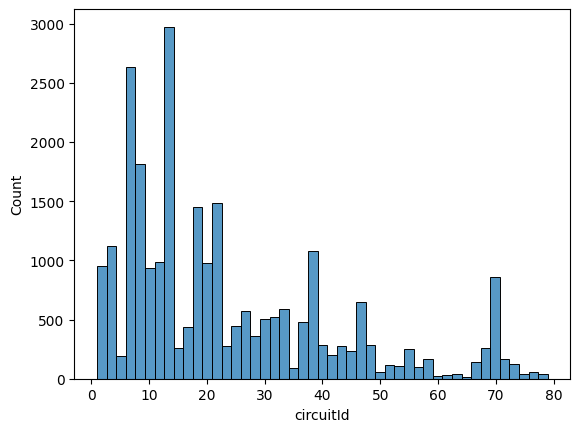

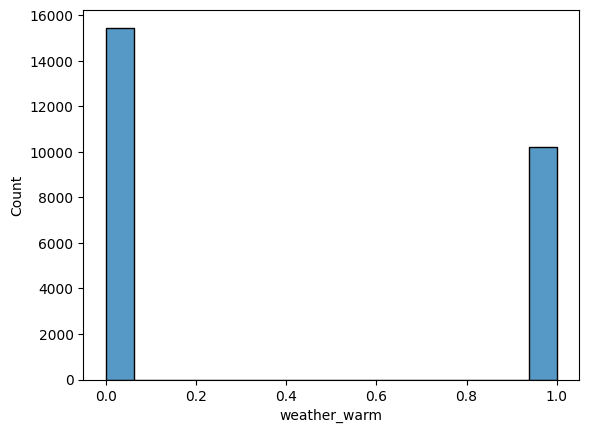

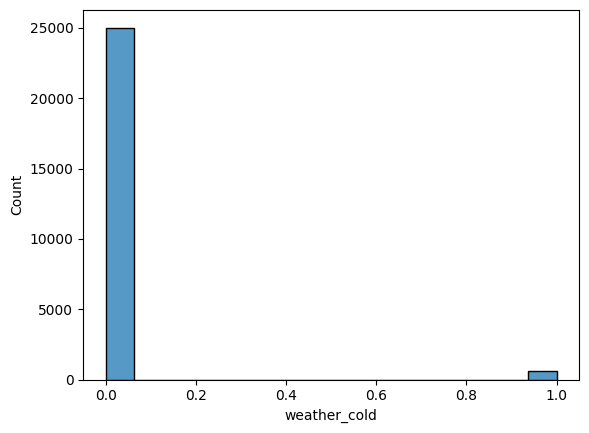

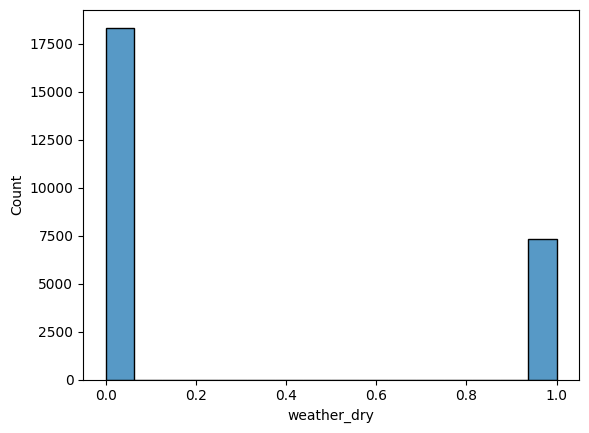

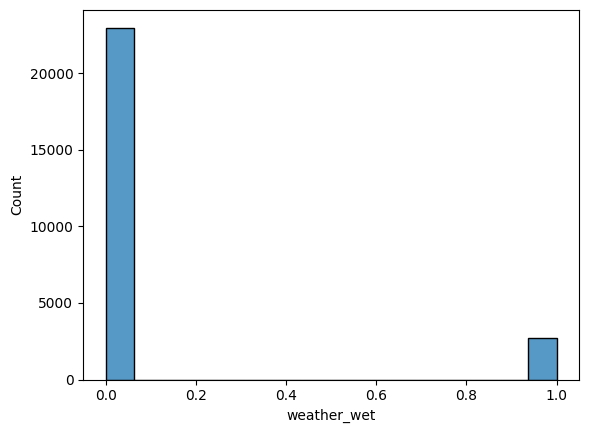

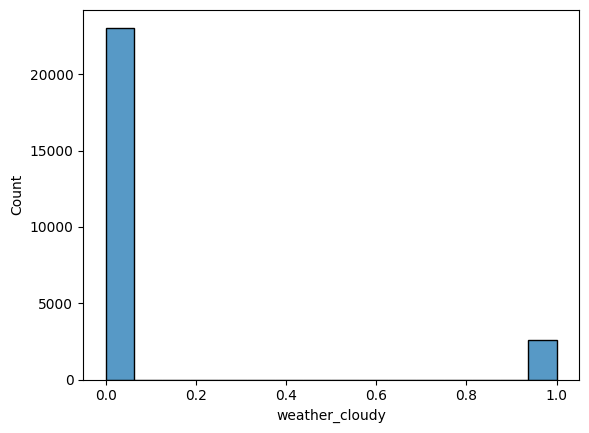

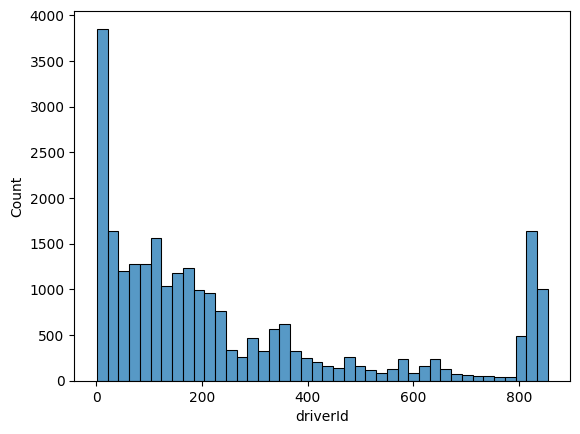

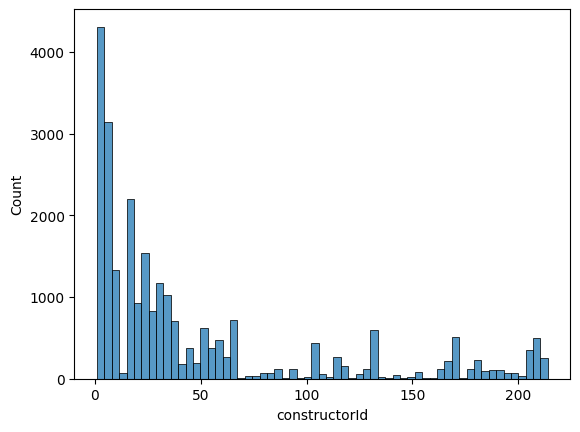

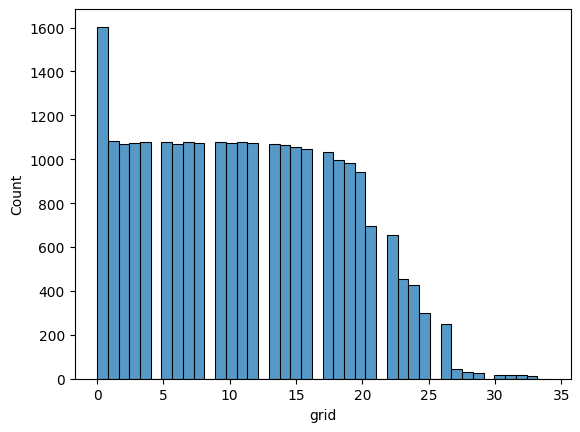

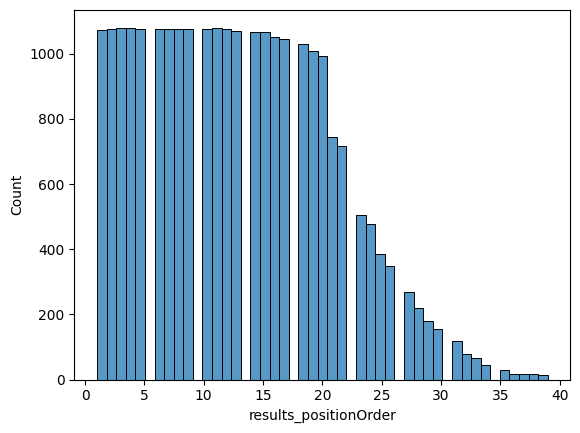

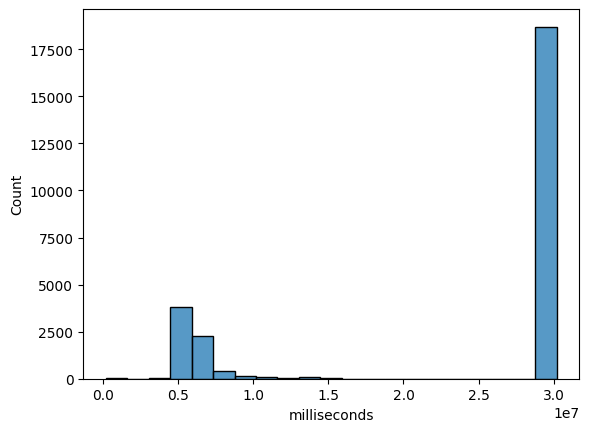

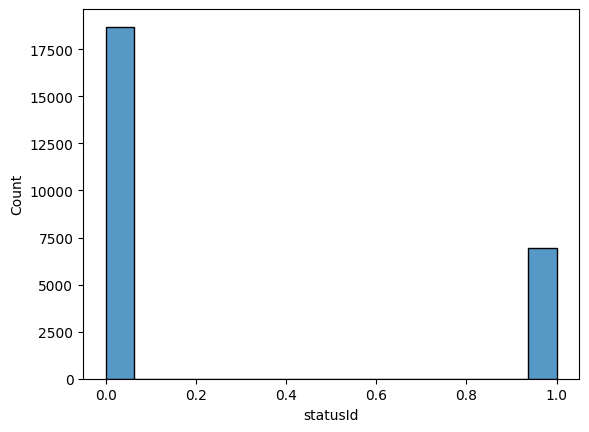

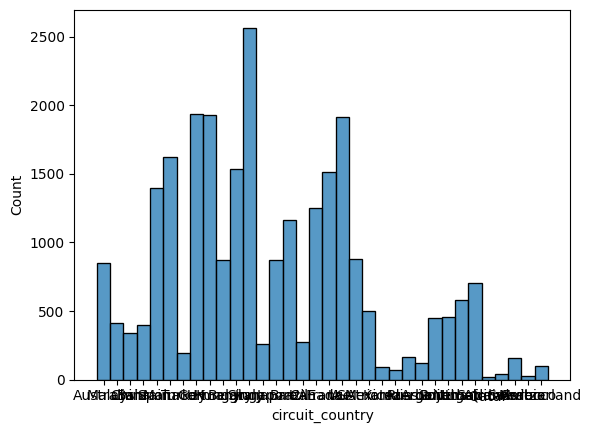

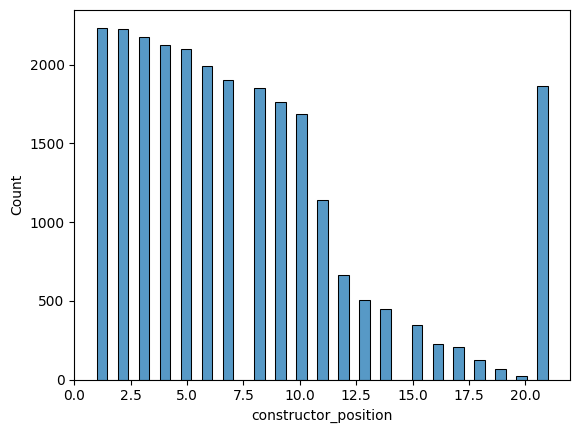

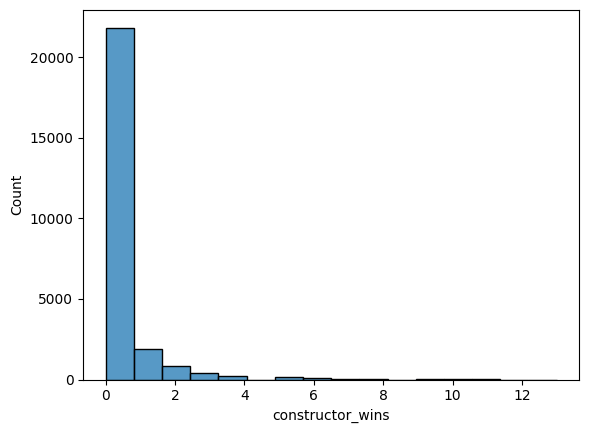

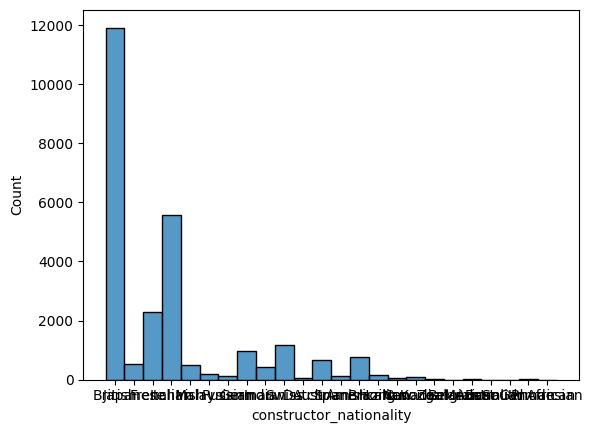

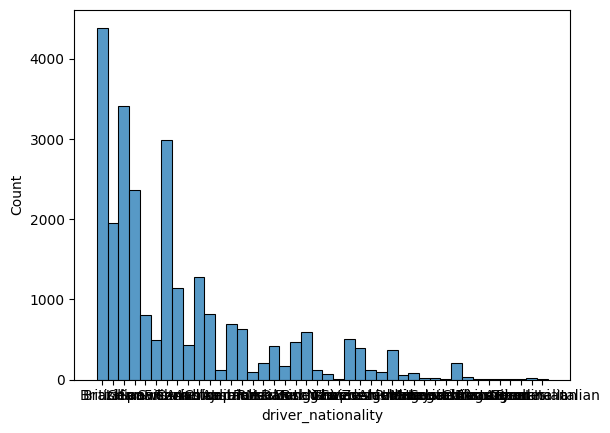

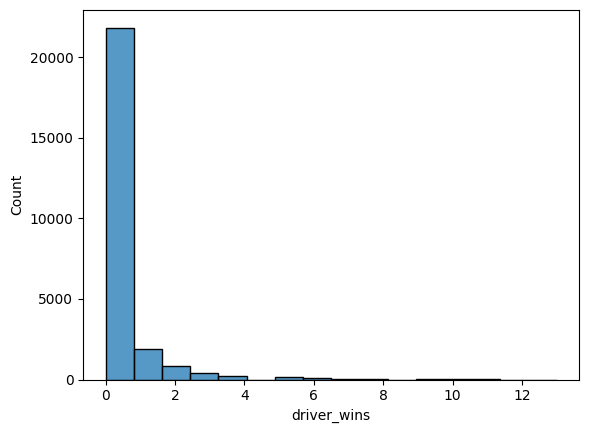

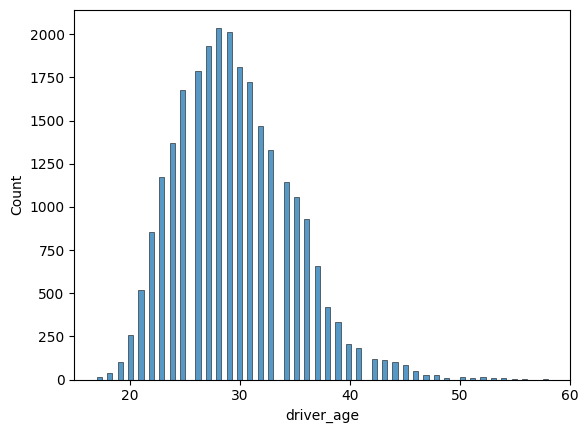

In [257]:
for i in df_after_dropping.columns: 
    sns.histplot(df_after_dropping[i])
    plt.show()

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



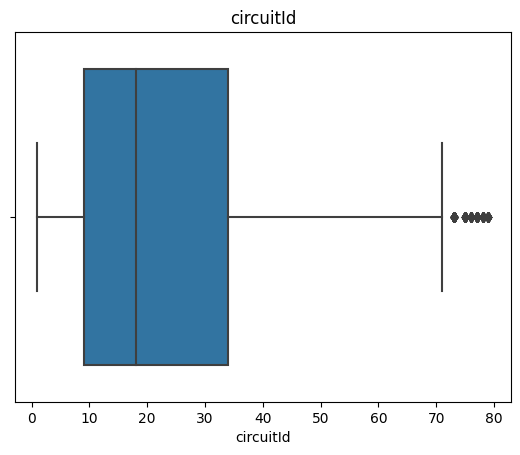

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



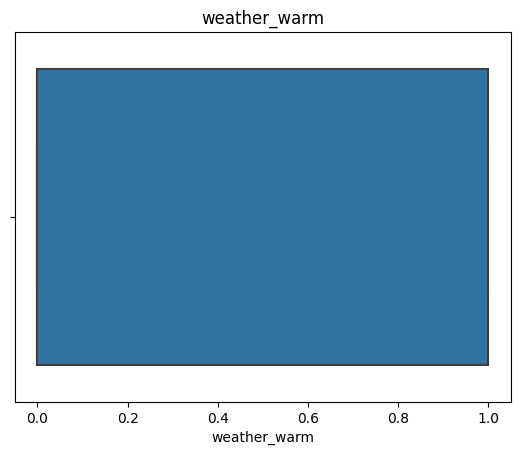

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



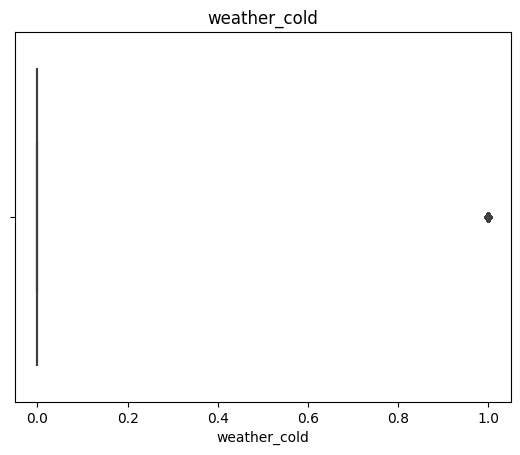

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



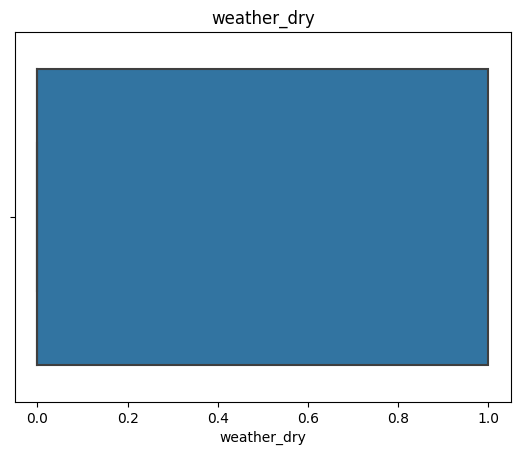

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



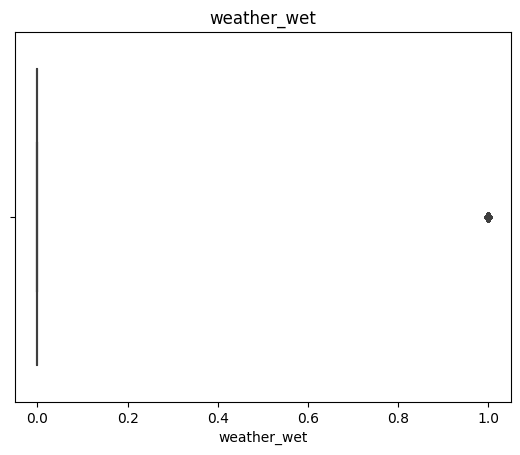

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



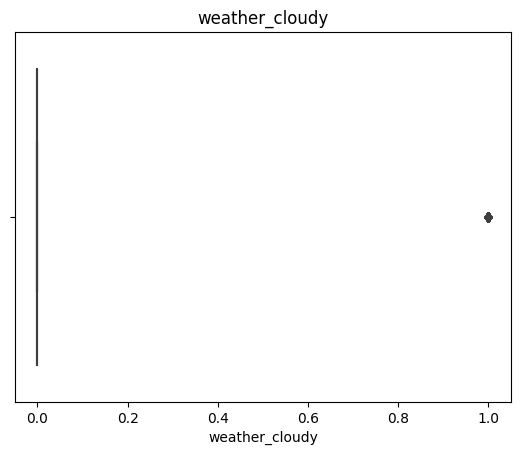

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



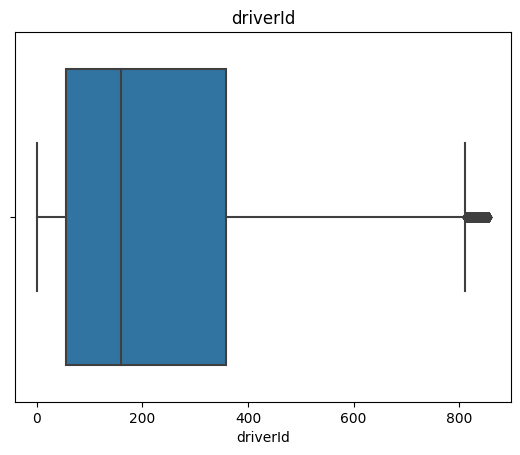

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



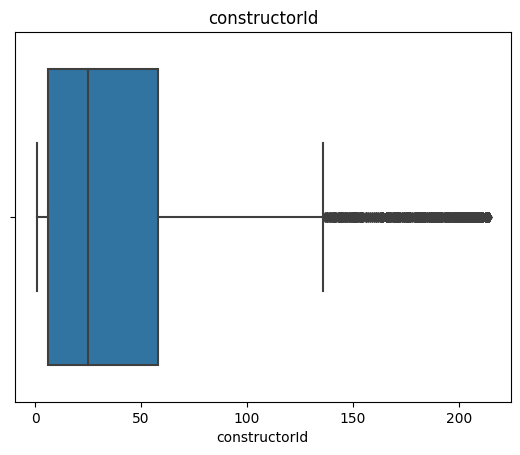

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



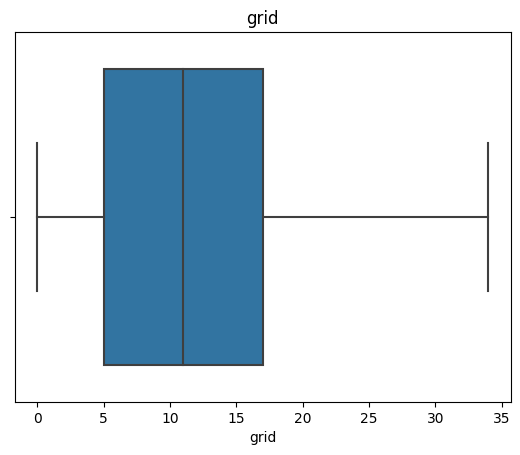

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



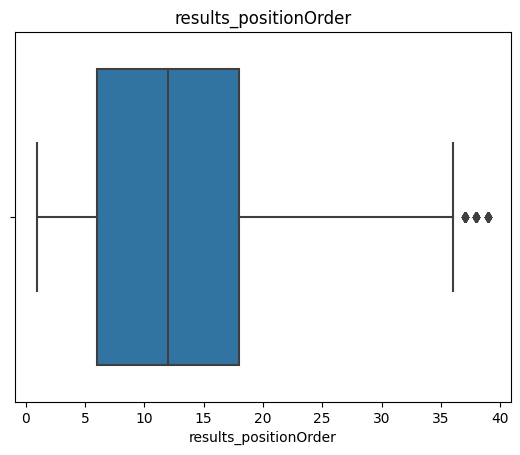

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



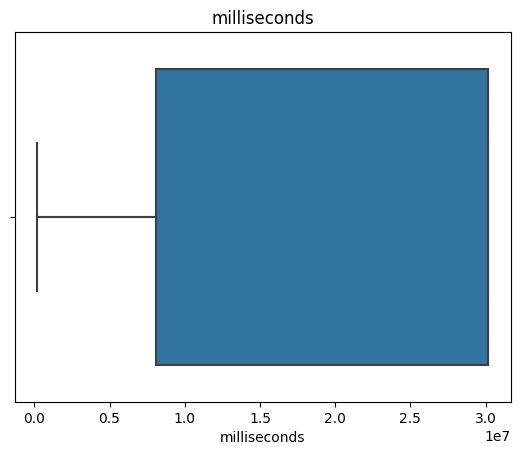

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



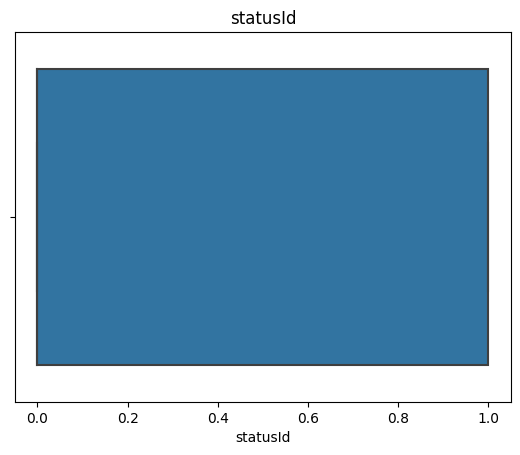

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



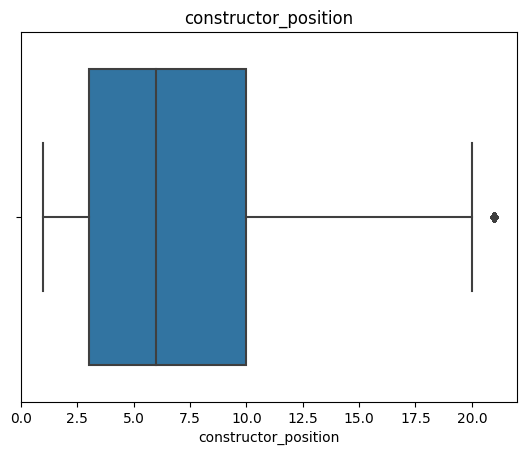

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



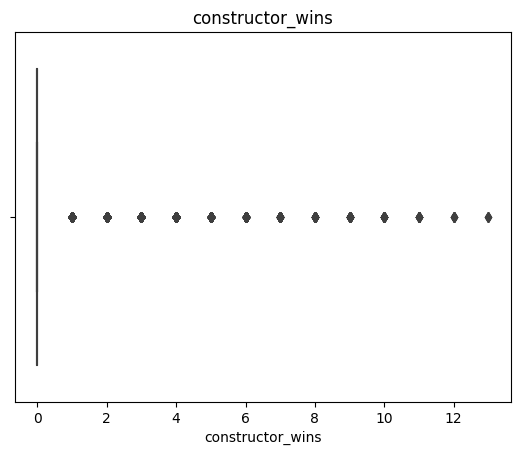

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



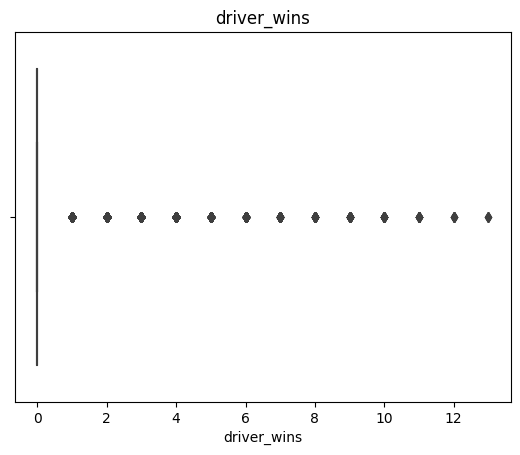

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



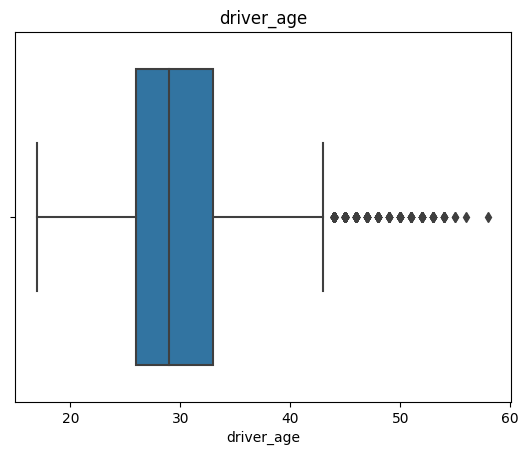

In [258]:
df_num = df_after_dropping.select_dtypes(include=[np.number])
for i in df_num.columns:
    sns.boxplot(df_num[i])
    plt.title(i)
    plt.show()

In [259]:
upper_limit = df_after_dropping["driver_age"].quantile(0.97)
df_after_dropping['driver_age'] = np.where(df_after_dropping['driver_age'] > upper_limit, upper_limit, df_after_dropping['driver_age'])

In [260]:
dictDriverCountry={'Argentine':1,'Australian':2,'Austrian':3,'Belgian':6,'Brazilian':7,'Canadian':8,'Chinese':9,
'French':10,'German':11,'Hungarian':12,'Indian':13,'Italian':14,'Japanese':15,'Malaysian':17,
'Mexican':18,'Monegasque':19,'Portuguese':22,'Russian':24,'South African':27,'Spanish':28,
'Swedish':29,'Swiss':30,'British':33,'American':34,'American-Italian':14,'Argentine-Italian':1,
'Chilean':35,'Colombian':36,'Czech':37,'Danish':38,'Dutch':39,'East German':11,'Finnish':40,'Indonesian':41,'Irish':42,
'Liechtensteiner':43,'New Zealander':44,'Polish':45,'Rhodesian':46,'Thai':47,'Uruguayan':48,'Venezuelan':49
}

In [261]:
dictCircuitCountry = {'Argentina': 1, 'Australia': 2, 'Austria': 3, 'Azerbaijan': 4, 'Bahrain': 5, 'Belgium': 6, 
'Brazil': 7, 'Canada': 8, 'China': 9, 'France': 10, 'Germany': 11, 'Hungary': 12, 'India': 13, 'Italy': 14, 'Japan': 15, 
'Korea': 16, 'Malaysia': 17, 'Mexico': 18, 'Monaco': 19, 'Morocco': 20, 'Netherlands': 21, 'Portugal': 22, 'Qatar': 23, 
'Russia': 24, 'Saudi Arabia': 25, 'Singapore': 26, 'South Africa': 27, 'Spain': 28, 'Sweden': 29, 'Switzerland': 30, 
'Turkey': 31, 'UAE': 32, 'UK': 33, 'USA': 34}

In [262]:
df_after_dropping['circuit_country'] = df_after_dropping['circuit_country'].map(dictCircuitCountry)

In [263]:
df_after_dropping['driver_nationality'] = df_after_dropping['driver_nationality'].map(dictDriverCountry)

<AxesSubplot:>

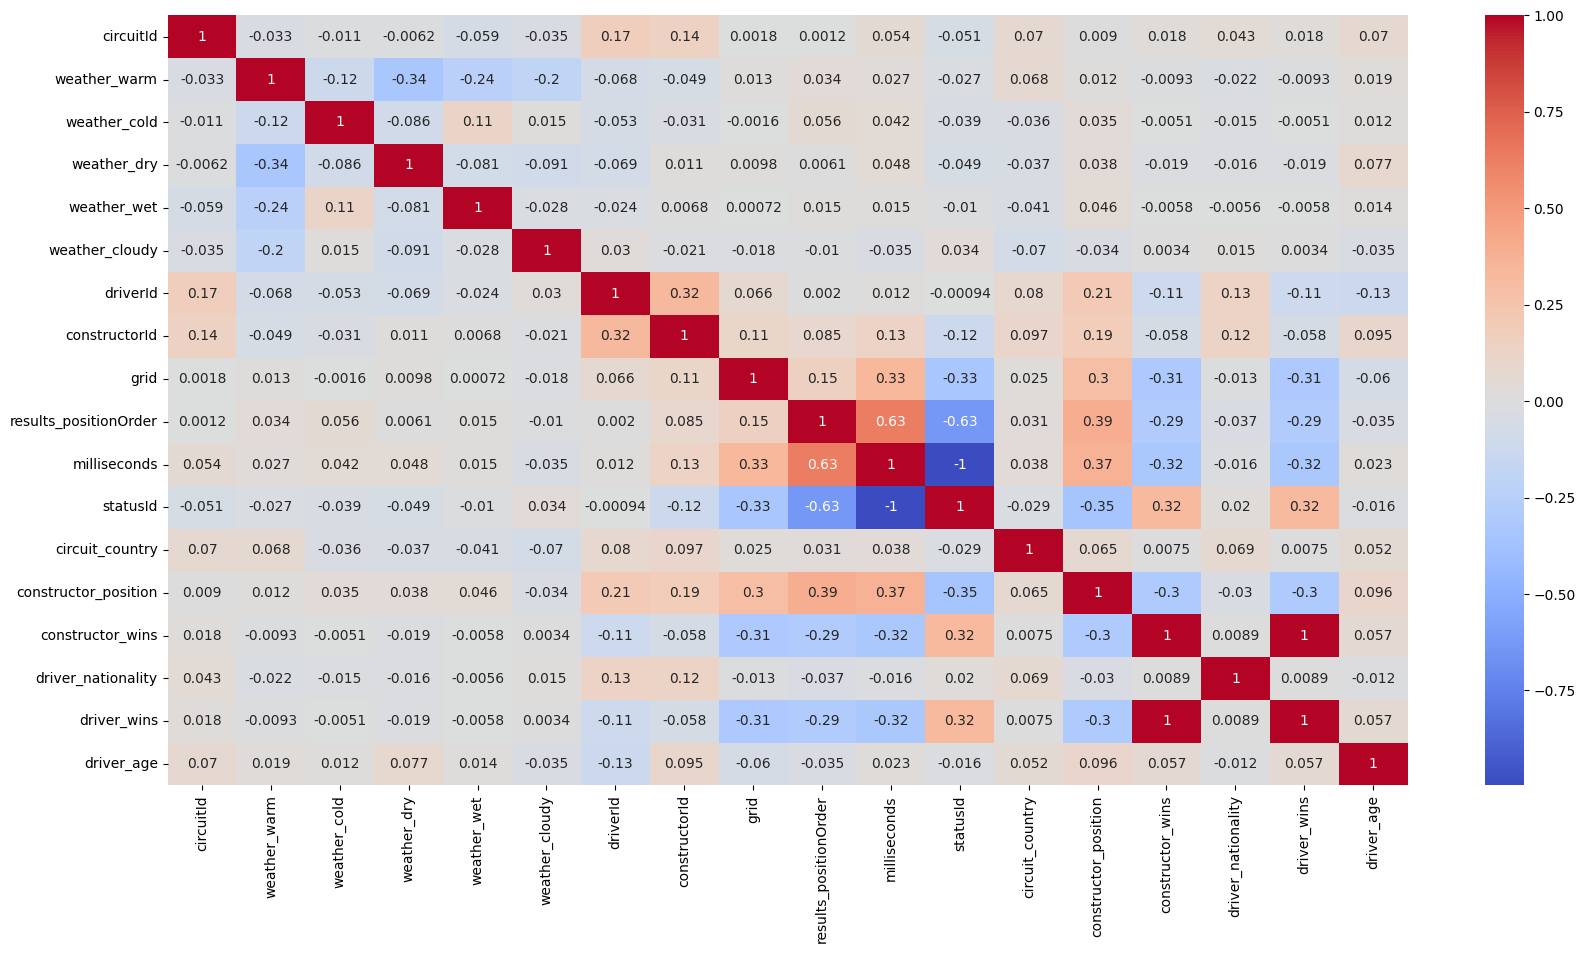

In [267]:
plt.figure(figsize=(20,10))
sns.heatmap(df_after_dropping.corr(), annot=True, cmap='coolwarm')

In [195]:
x_train, x_test, y_train, y_test = train_test_split(df_after_dropping.drop(columns = ['results_positionOrder']), df_after_dropping['results_positionOrder'], test_size = 0.15, random_state = 42, stratify=df_after_dropping['results_positionOrder'])

In [196]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [197]:
x_train['milliseconds'] = min_max_scaler.fit_transform(x_train[['milliseconds']])
x_test['milliseconds'] = min_max_scaler.transform(x_test[['milliseconds']])

In [198]:
x_train['driver_age'] = min_max_scaler.fit_transform(x_train[['driver_age']])
x_test['driver_age'] = min_max_scaler.transform(x_test[['driver_age']])

In [199]:
x_train['driver_wins'] = standard_scaler.fit_transform(x_train[['driver_wins']])
x_test['driver_wins'] = standard_scaler.transform(x_test[['driver_wins']])

In [200]:
x_train['constructor_wins'] = standard_scaler.fit_transform(x_train[['constructor_wins']])
x_test['constructor_wins'] = standard_scaler.transform(x_test[['constructor_wins']])

In [204]:
encoder = TargetEncoder(cols = ['constructor_nationality', 'driverId', 'constructorId', 'circuitId'], smoothing = 10, min_samples_leaf = 20)
# encoder = PolynomialWrapper(encoder_target)
x_train = encoder.fit_transform(x_train, y_train)
x_test = encoder.transform(x_test)

In [205]:
x_train

,circuitId,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driverId,constructorId,grid,milliseconds,statusId,circuit_country,constructor_position,constructor_wins,constructor_nationality,driver_nationality,driver_wins,driver_age
3790,14.977199,1.0,0.0,0.0,0.0,0.0,9.558559,10.877811,3,0.203631,1,22,1.0,-0.310642,12.988650,33,-0.310642,0.250000
8244,12.644477,0.0,0.0,0.0,0.0,0.0,10.874843,9.847307,11,1.000000,0,19,7.0,-0.310642,13.292721,10,-0.310642,0.291667
10248,13.521902,0.0,0.0,1.0,0.0,0.0,12.478875,13.226542,15,1.000000,0,11,7.0,-0.310642,12.988650,33,-0.310642,0.416667
17254,13.021583,1.0,0.0,0.0,0.0,0.0,14.031363,15.684598,10,1.000000,0,34,9.0,-0.310642,12.988650,7,-0.310642,0.625000
1399,12.644477,1.0,0.0,0.0,0.0,0.0,8.219781,5.829787,7,1.000000,0,19,5.0,-0.310642,10.427890,11,-0.310642,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,10.929490,1.0,0.0,0.0,0.0,0.0,4.682171,5.829787,5,0.181248,1,34,1.0,8.721213,10.427890,33,8.721213,0.708333
3904,13.241814,1.0,0.0,0.0,0.0,1.0,9.897959,13.046979,11,1.000000,0,33,6.0,-0.310642,12.988650,2,-0.310642,0.375000
9087,12.413223,1.0,0.0,0.0,0.0,0.0,14.151237,14.318533,18,1.000000,0,10,9.0,-0.310642,12.988650,39,-0.310642,0.500000
9606,12.221323,0.0,0.0,0.0,0.0,0.0,12.140296,12.832084,0,1.000000,0,7,21.0,-0.310642,13.038614,40,-0.310642,0.666667


In [214]:
x_train['constructor_nationality'] = standard_scaler.fit_transform(x_train[['constructor_nationality']])
x_test['constructor_nationality'] = standard_scaler.transform(x_test[['constructor_nationality']])

In [215]:
x_train['driverId'] = standard_scaler.fit_transform(x_train[['driverId']])
x_test['driverId'] = standard_scaler.transform(x_test[['driverId']])

In [216]:
x_train['constructorId'] = standard_scaler.fit_transform(x_train[['constructorId']])
x_test['constructorId'] = standard_scaler.transform(x_test[['constructorId']])

In [217]:
x_train['circuitId'] = standard_scaler.fit_transform(x_train[['circuitId']])
x_test['circuitId'] = standard_scaler.transform(x_test[['circuitId']])

In [218]:
pd.concat([x_train, y_train], axis = 1).to_csv('./data/train.csv', index = False)
pd.concat([x_test, y_test], axis = 1).to_csv('./data/test.csv', index = False)

#### Final EDA

In [224]:
data = pd.read_csv('./data/train.csv')

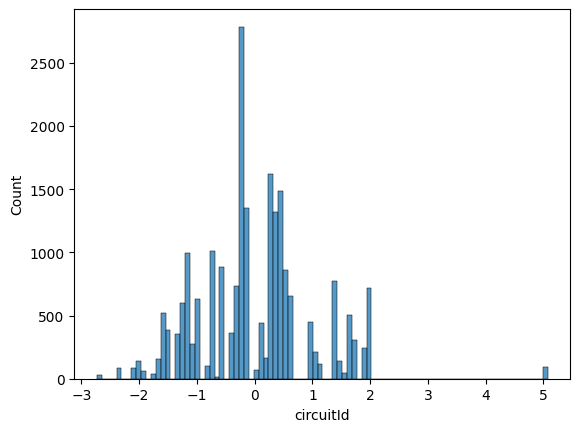

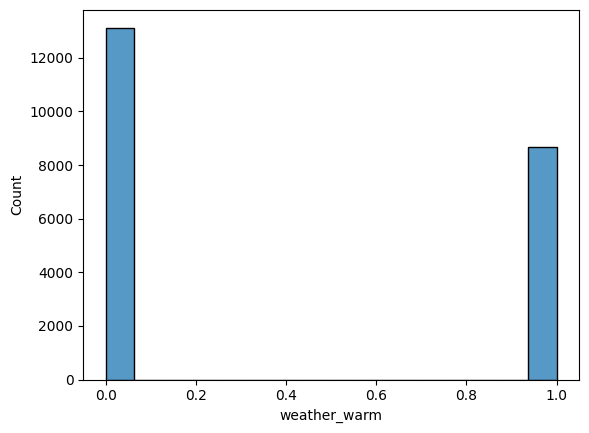

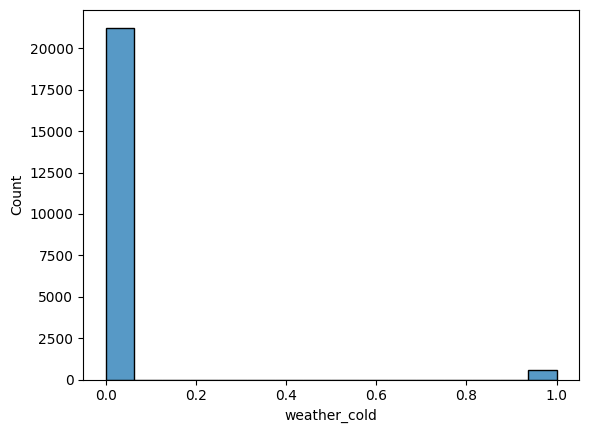

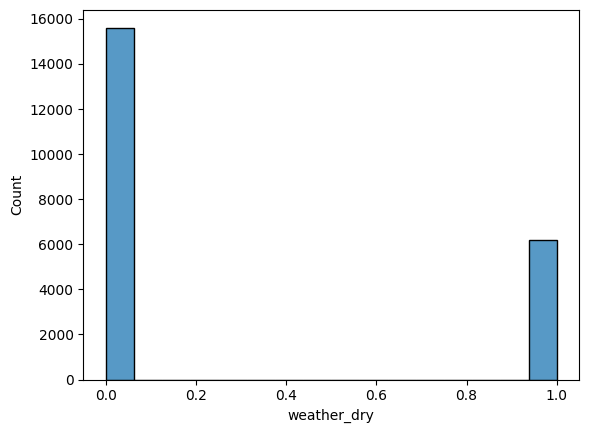

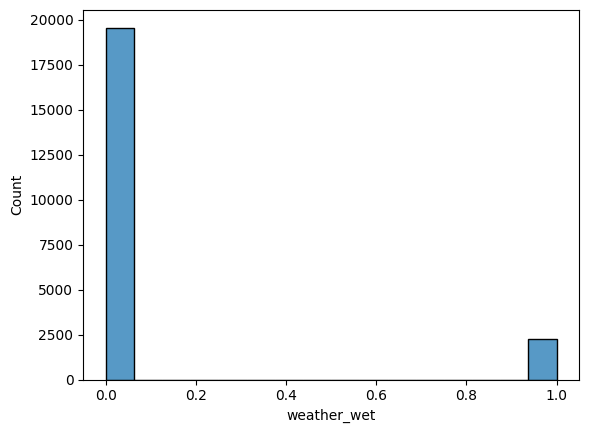

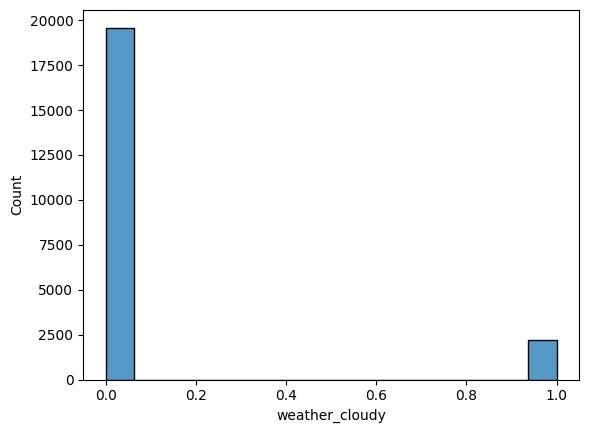

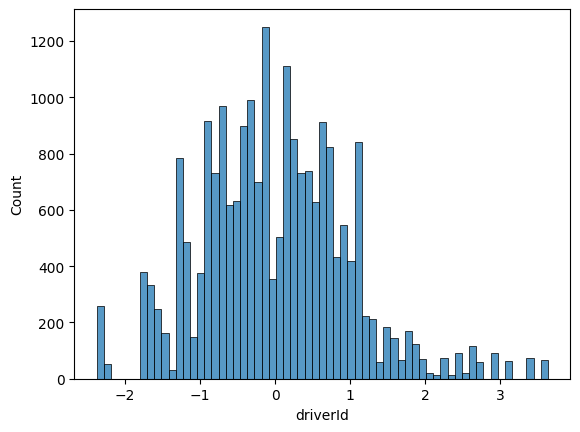

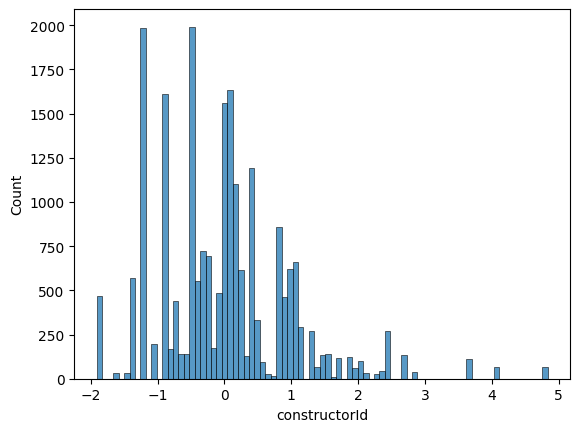

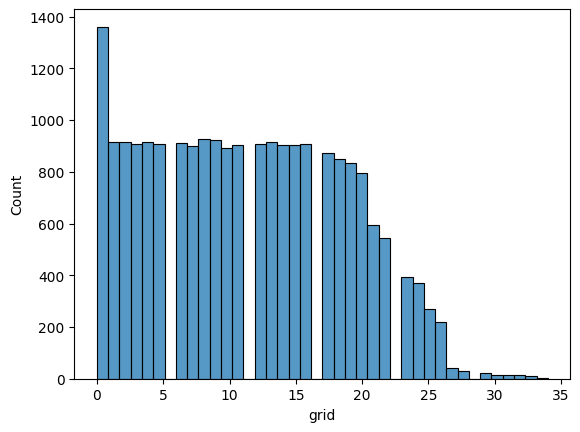

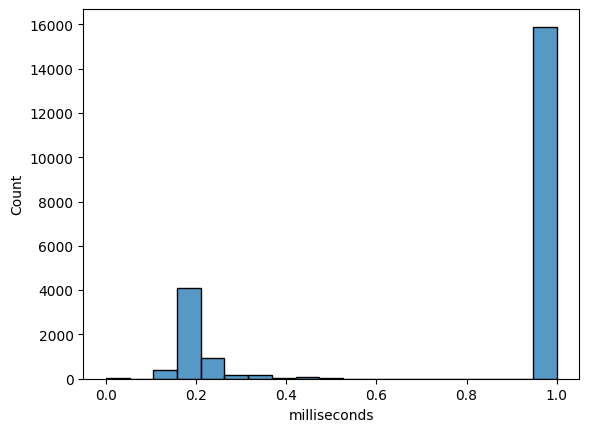

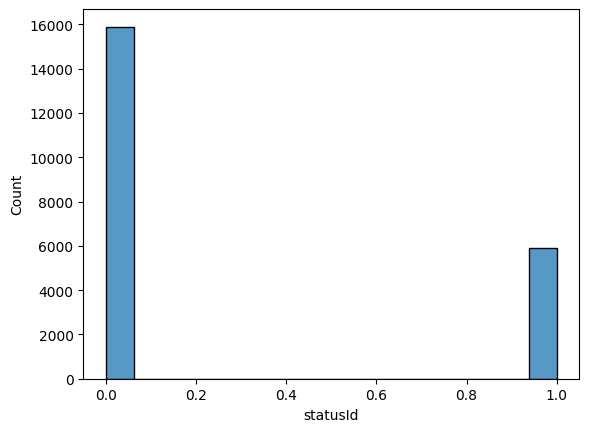

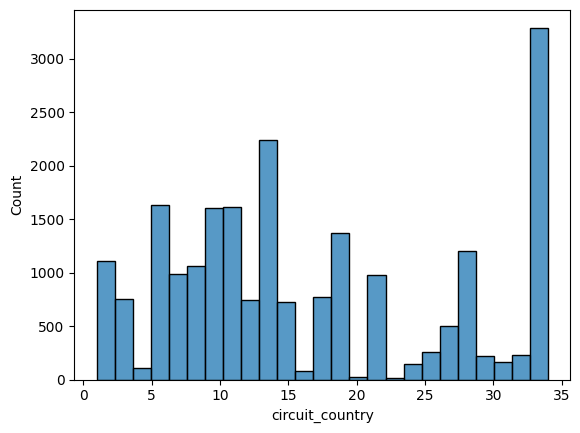

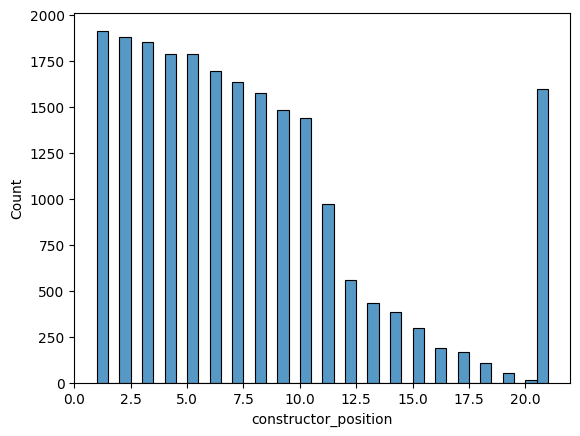

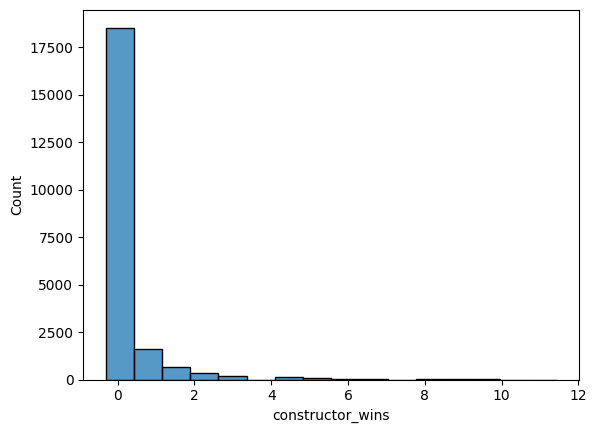

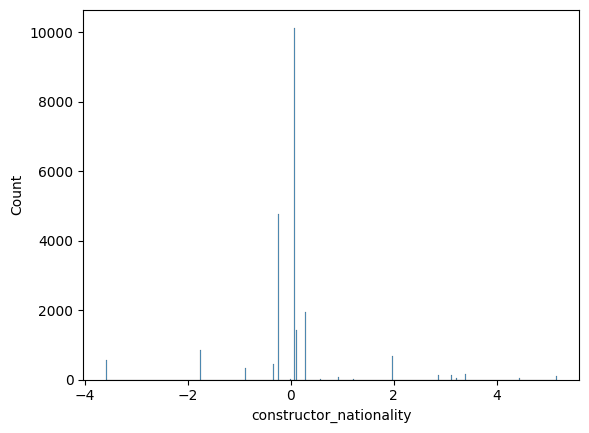

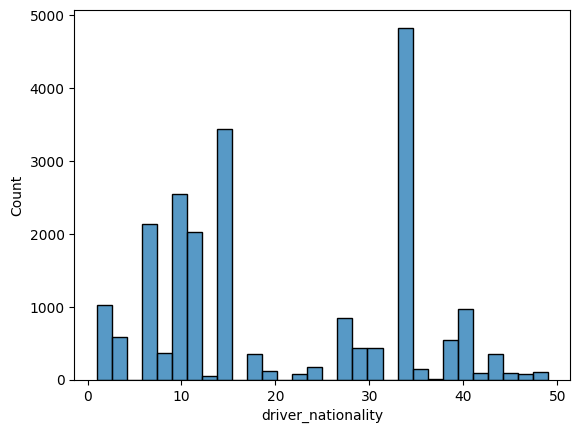

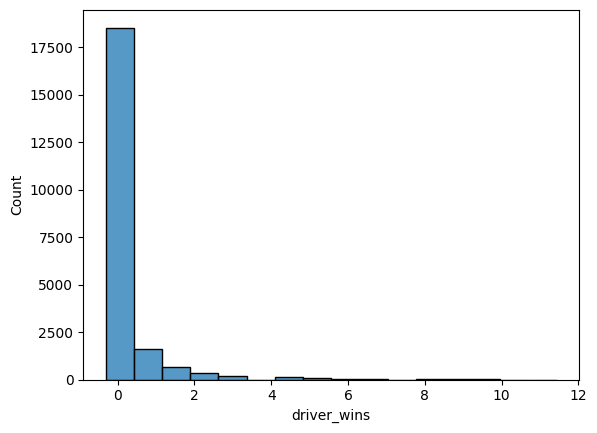

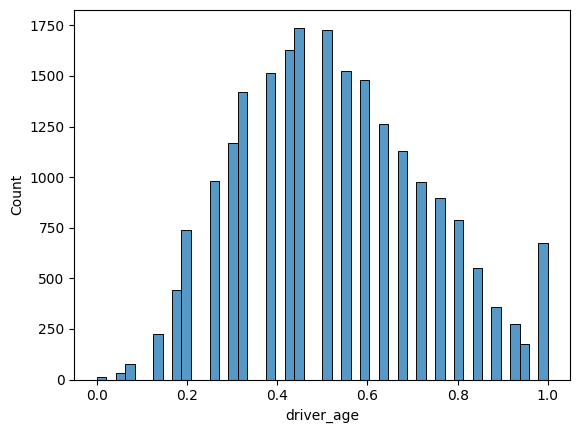

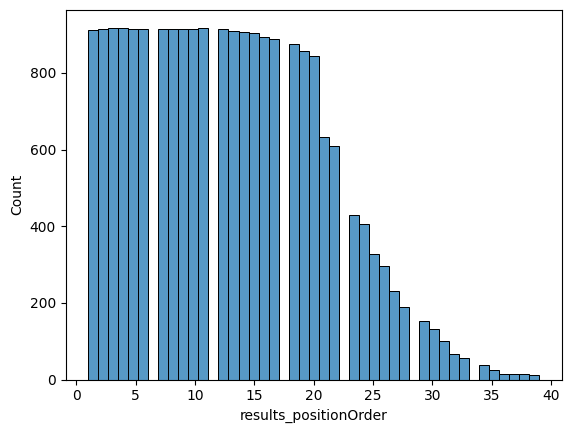

In [227]:
for i in data.columns: 
    sns.histplot(data[i])
    plt.show()

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



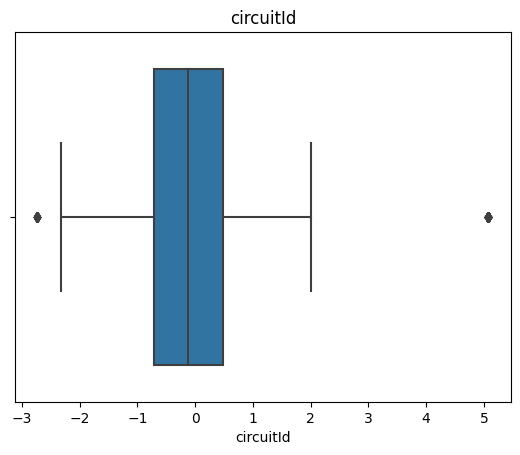

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



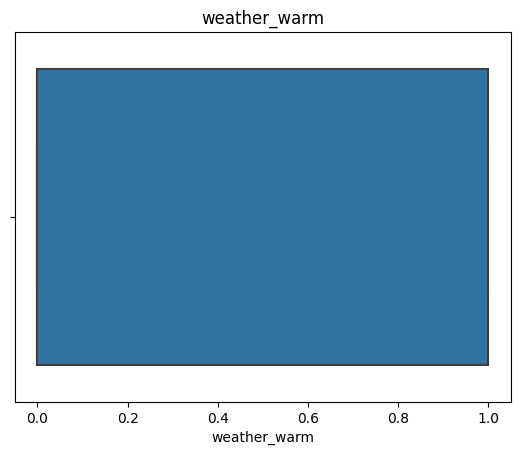

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



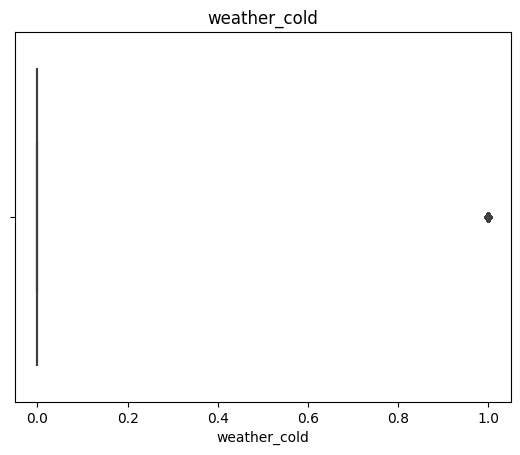

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



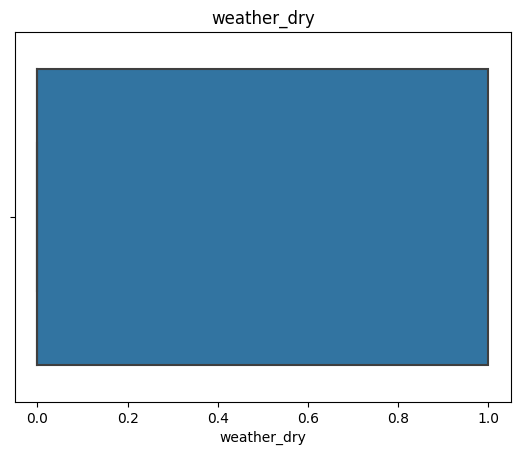

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



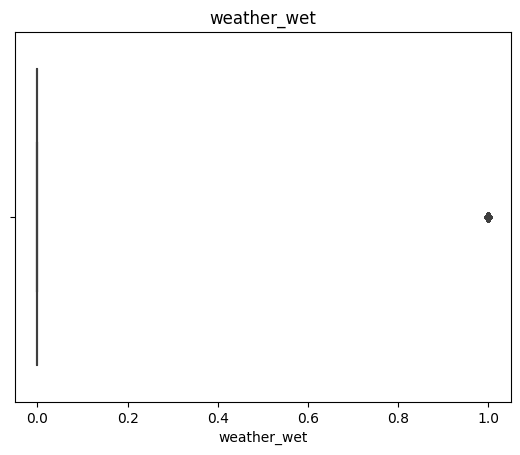

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



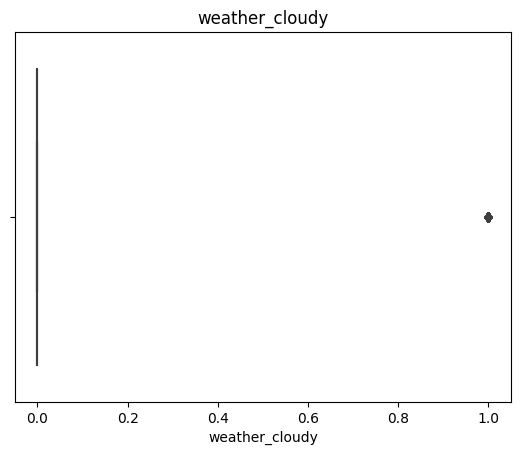

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



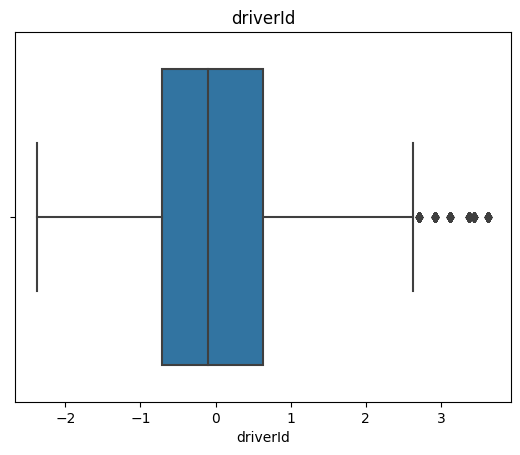

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



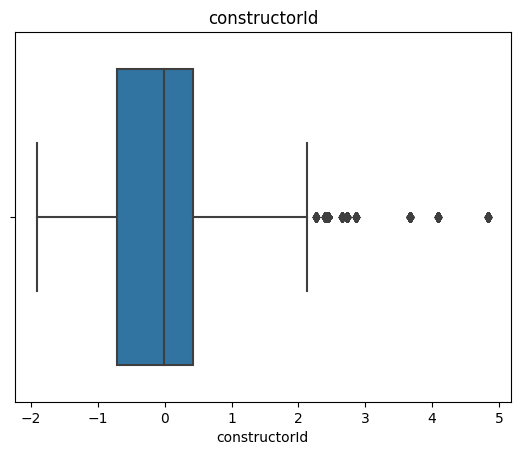

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



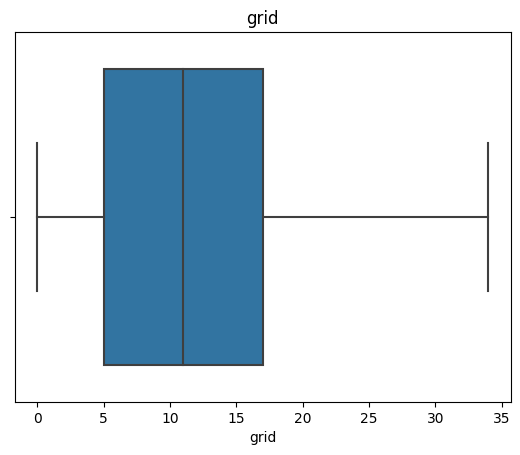

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



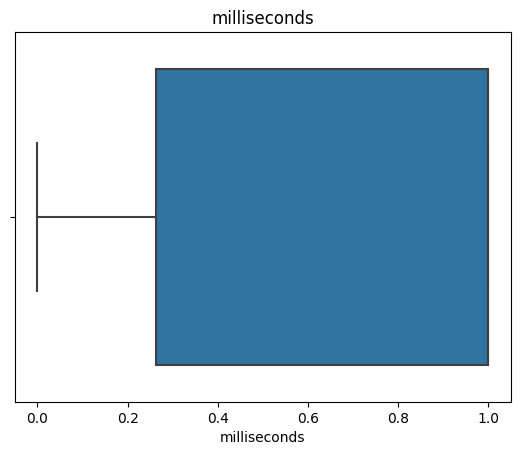

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



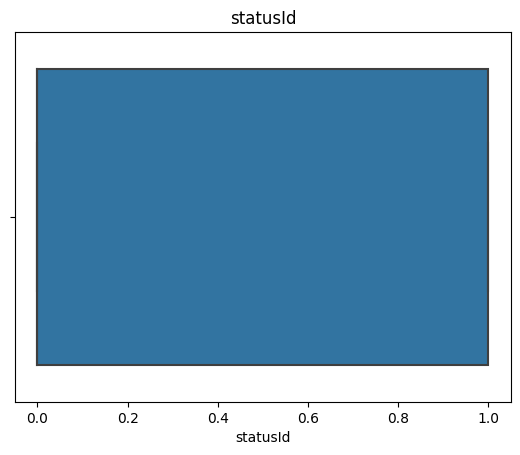

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



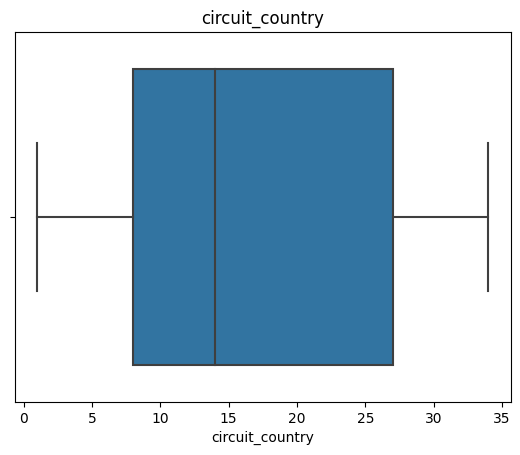

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



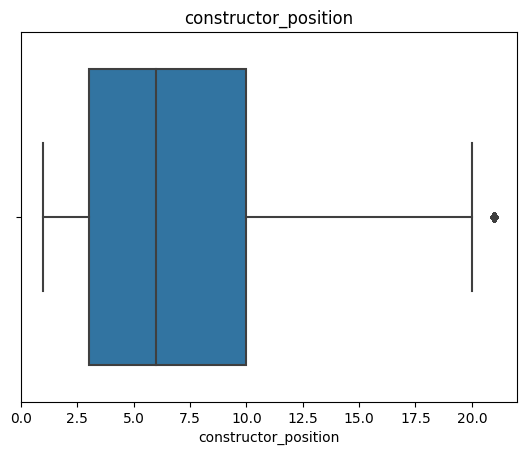

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



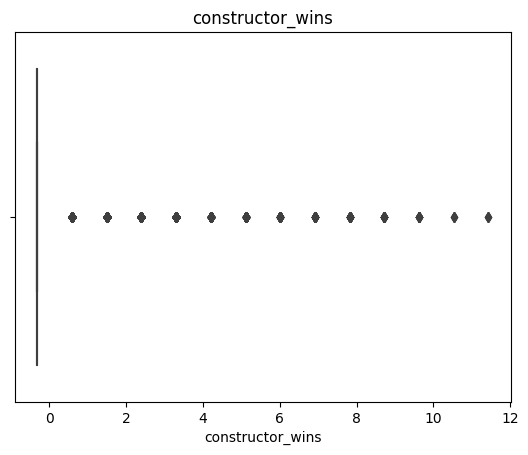

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



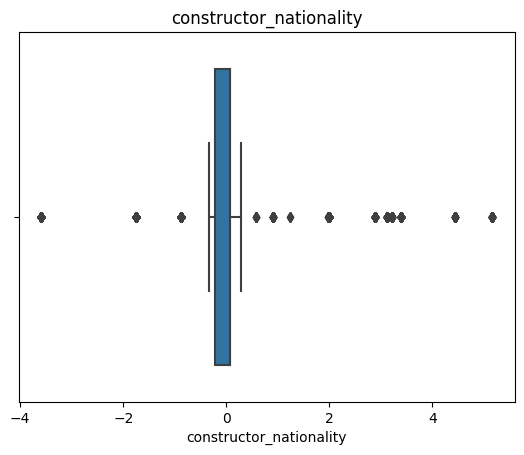

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



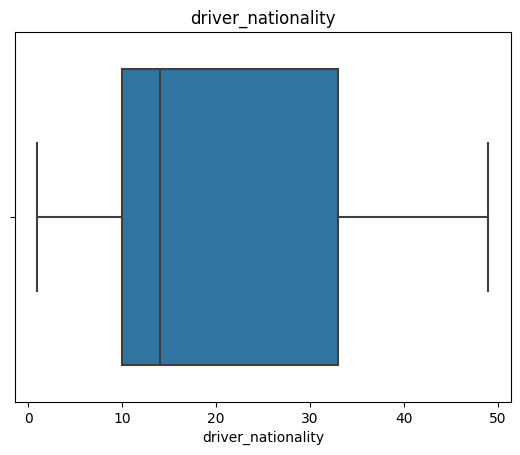

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



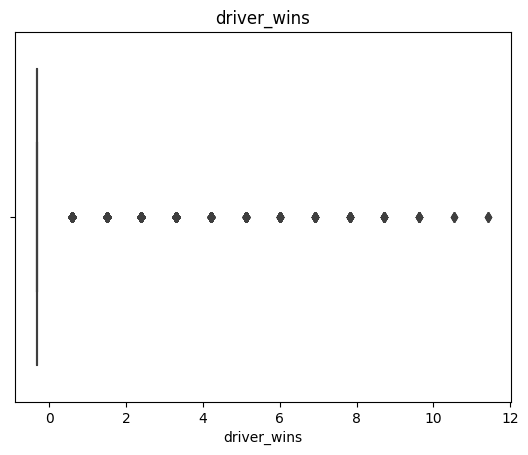

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



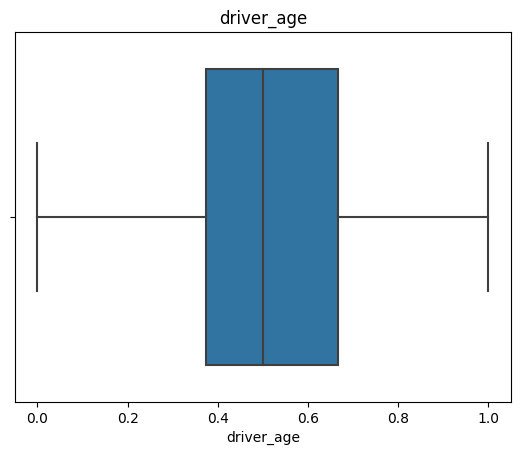

c:\Users\nipun\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



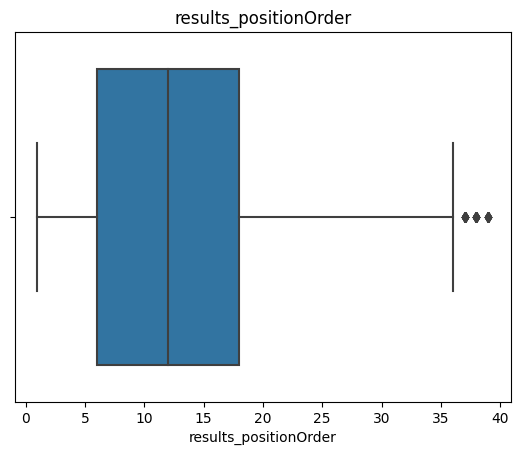

In [229]:
df_num = data.select_dtypes(include=[np.number])
for i in df_num.columns:
    sns.boxplot(df_num[i])
    plt.title(i)
    plt.show()

<AxesSubplot:>

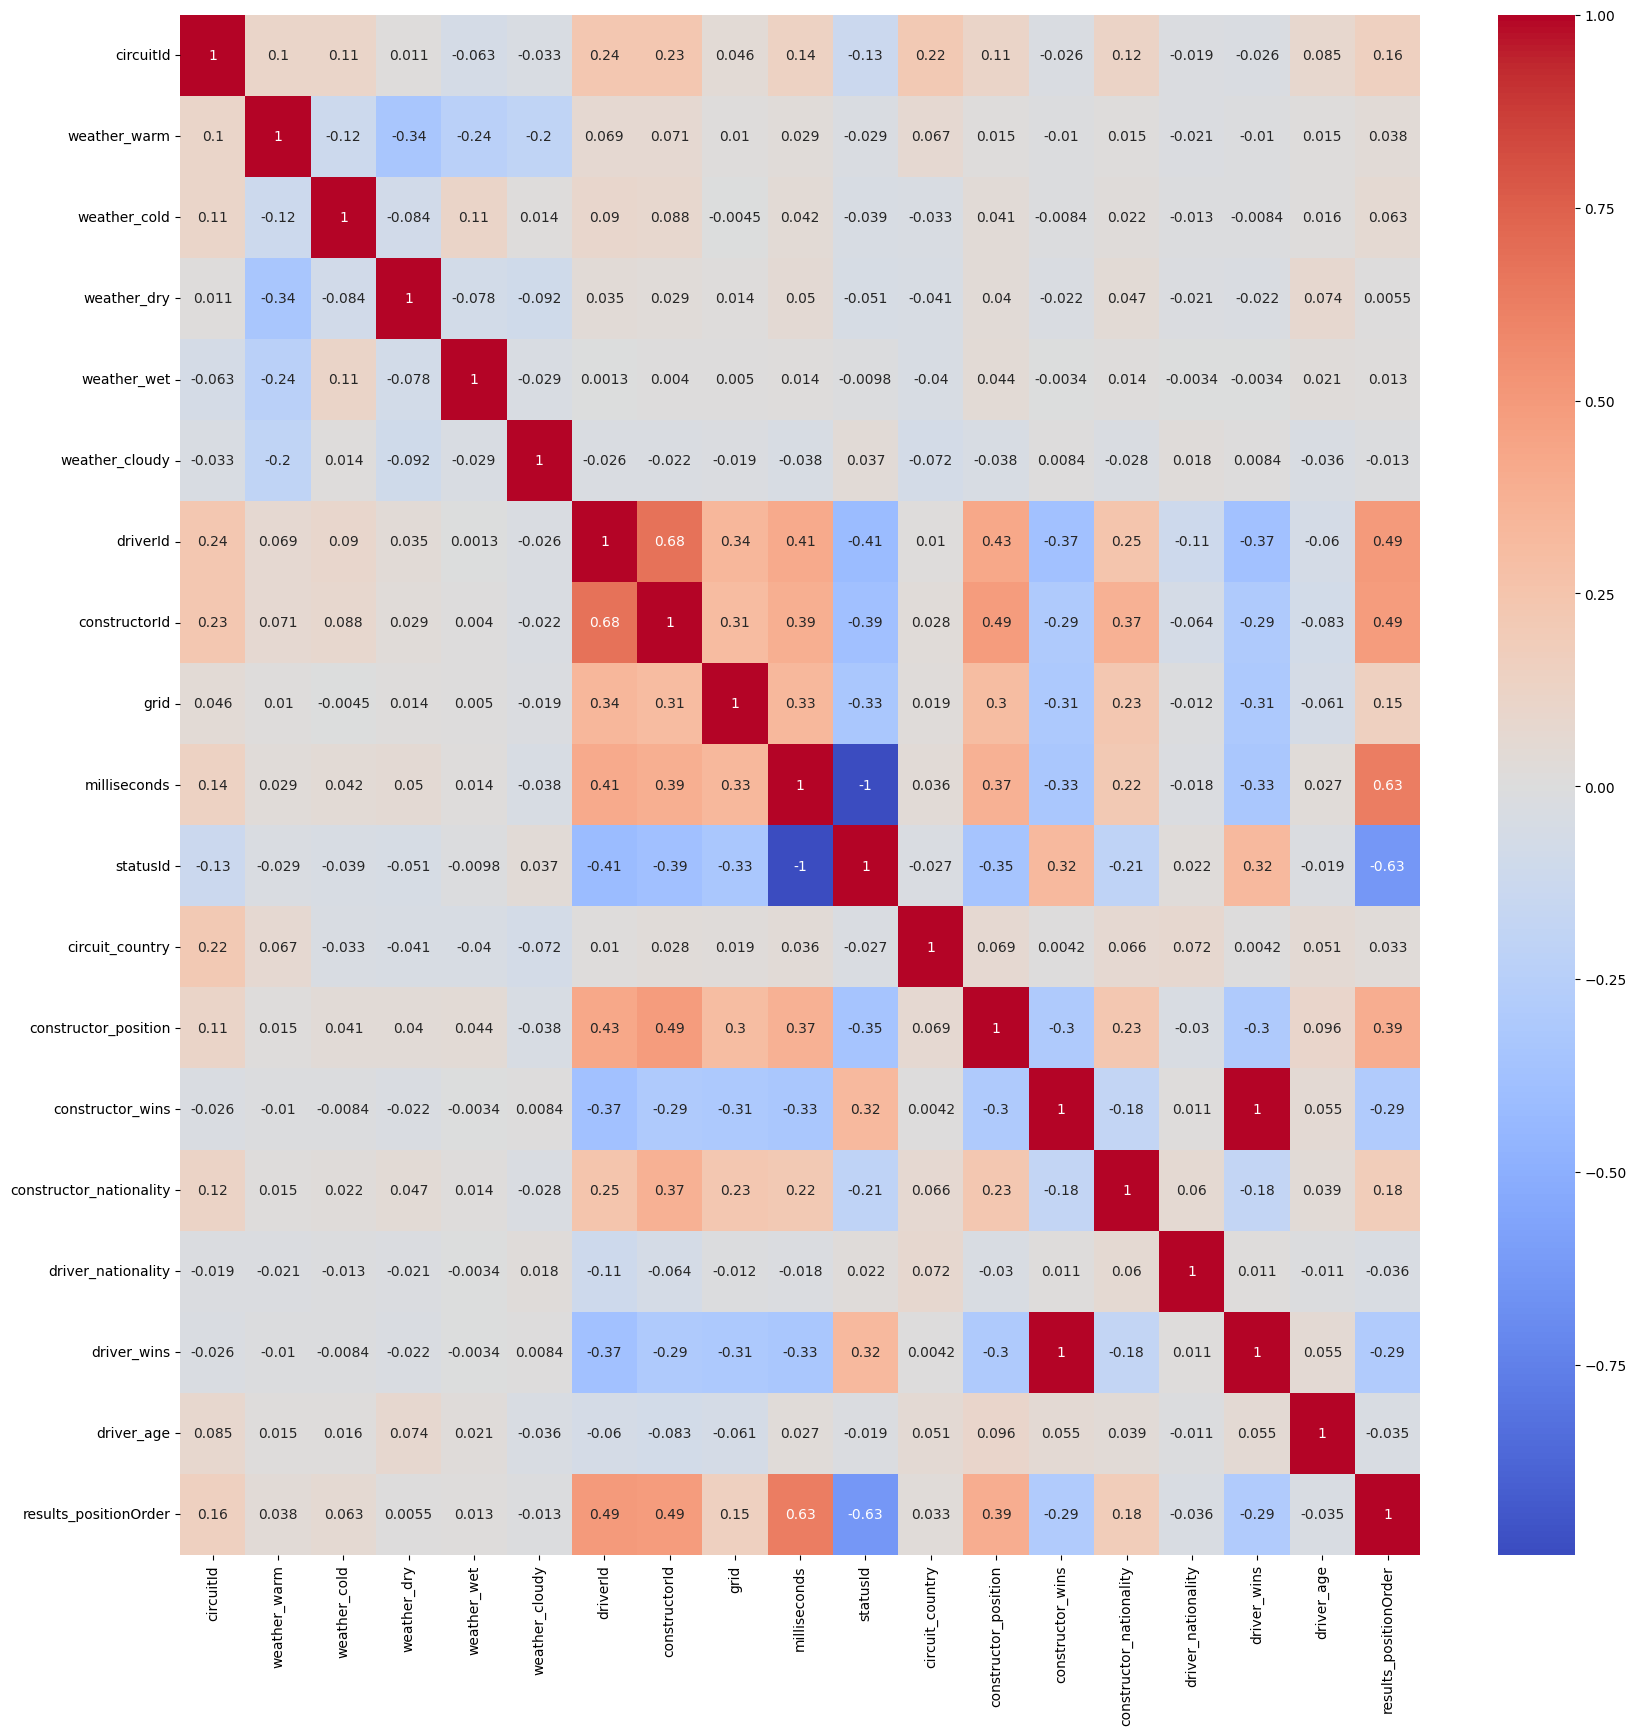

In [266]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm')

<AxesSubplot:xlabel='results_positionOrder', ylabel='count'>

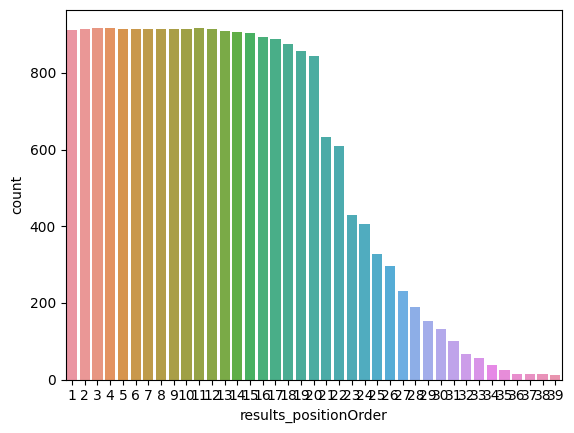

In [232]:
sns.countplot(x = 'results_positionOrder', data = data)